In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os

In [4]:
IMG_DIR = "function_ai_dataset_images"
LABEL_PATH = "function_outputs.npy"
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3
IMG_SIZE = 64  # assuming square images

In [5]:
IMG_DIR = "function_ai_dataset_images"
LABEL_PATH = "function_outputs.npy"
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3
IMG_SIZE = 64  # assuming square images

# -------------------------------
# Custom Dataset
# -------------------------------
class FunctionImageDataset(Dataset):
    def __init__(self, img_dir, label_path, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = np.load(label_path)
        self.img_files = sorted(os.listdir(img_dir), key=lambda x: int(x.split('_')[-1].split('.')[0]))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

In [10]:
IMG_DIR = 'function_ai_dataset_images'
LABEL_PATH = 'function_outputs.npy'
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Grayscale normalization
])


In [11]:
dataset = FunctionImageDataset(IMG_DIR, LABEL_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [12]:
class FunctionApproximatorCNN(nn.Module):
    def __init__(self, output_dim):
        super(FunctionApproximatorCNN, self).__init__()
        
        # CNN Feature Extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 8x8
        )
        
        # Fully connected approximator (ANN)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [13]:
OUTPUT_DIM = dataset[0][1].shape[0]  # E.g., 64 values per function output vector
model = FunctionApproximatorCNN(output_dim=OUTPUT_DIM)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
NUM_EPOCHS = 20

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.2627
Epoch [2/20], Loss: 0.2442
Epoch [3/20], Loss: 0.2417
Epoch [4/20], Loss: 0.2421
Epoch [5/20], Loss: 0.2429
Epoch [6/20], Loss: 0.2415
Epoch [7/20], Loss: 0.2410
Epoch [8/20], Loss: 0.2441
Epoch [9/20], Loss: 0.2415
Epoch [10/20], Loss: 0.2417
Epoch [11/20], Loss: 0.2410
Epoch [12/20], Loss: 0.2410
Epoch [13/20], Loss: 0.2421
Epoch [14/20], Loss: 0.2424
Epoch [15/20], Loss: 0.2413
Epoch [16/20], Loss: 0.2420
Epoch [17/20], Loss: 0.2422
Epoch [18/20], Loss: 0.2416
Epoch [19/20], Loss: 0.2419
Epoch [20/20], Loss: 0.2413


In [15]:
torch.save(model.state_dict(), "function_model.pth")


In [16]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Evaluation Loss: {avg_loss:.4f}")


In [18]:
evaluate(model, dataloader)


Evaluation Loss: 0.2400


In [19]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataset, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            image, true_output = dataset[i]
            image_batch = image.unsqueeze(0)  # add batch dimension
            predicted_output = model(image_batch).squeeze()

            x = range(len(true_output))
            plt.figure(figsize=(6, 3))
            plt.plot(x, true_output.numpy(), label="True", linewidth=2)
            plt.plot(x, predicted_output.numpy(), label="Predicted", linestyle='--')
            plt.title(f"Sample {i}")
            plt.legend()
            plt.grid(True)
            plt.show()


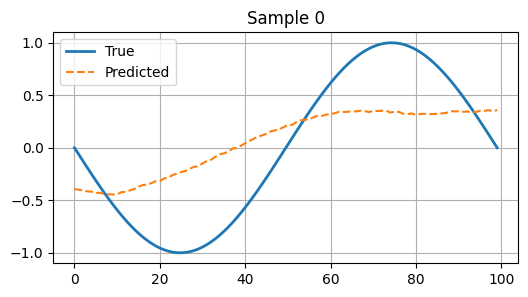

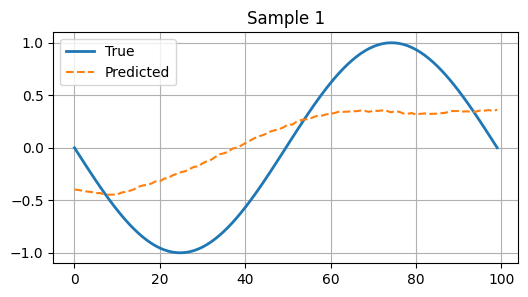

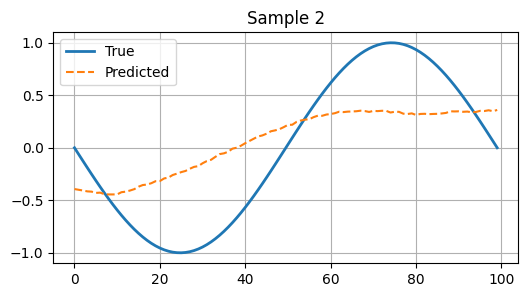

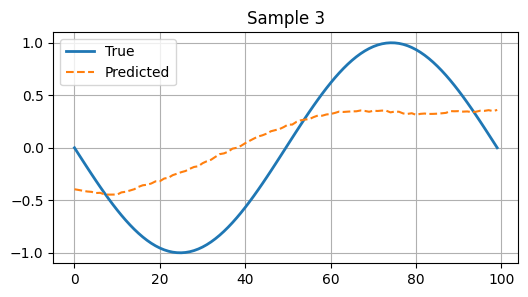

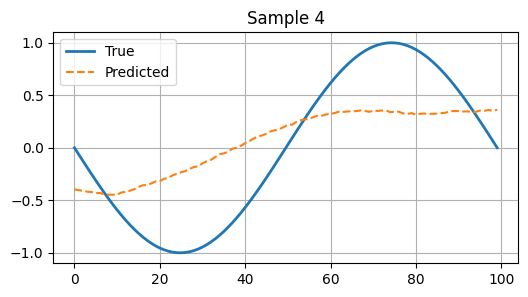

In [20]:
visualize_predictions(model, dataset)


In [21]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def predict_from_gui_image(model, pil_img):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    model.eval()
    with torch.no_grad():
        img_tensor = transform(pil_img).unsqueeze(0)  # Add batch dimension
        output = model(img_tensor).squeeze().numpy()
    return output


In [22]:
predicted_function = predict_from_gui_image(model, pil_img)


NameError: name 'pil_img' is not defined